## MultiChartsBuild
Python API to be called from C++ DLL

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py
import plotly

Using TensorFlow backend.


In [128]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [95]:
# Inputting dummy data
dataset = pd.read_csv('input/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [120]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,3:4].values
test_set = dataset['2017':].iloc[:,3:4].values
training_set

array([[ 82.06],
       [ 81.95],
       [ 82.5 ],
       ...,
       [166.19],
       [166.6 ],
       [165.99]])

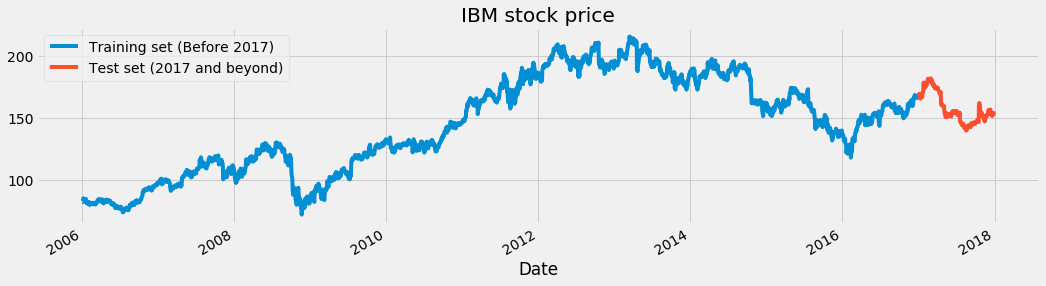

In [121]:
# 'Close' attribute for prices
dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [122]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [123]:
# creating a data structure with 60 timesteps and 1 output
# for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [124]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## LSTM Model
Training the data with a basic Long Short Term Memory RNN to avoid VG

In [129]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
2709/2709 [==============================] - 28s 10ms/step - loss: 0.0220
Epoch 2/50
2709/2709 [==============================] - 34s 13ms/step - loss: 0.0107
Epoch 3/50
2709/2709 [==============================] - 35s 13ms/step - loss: 0.0084
Epoch 4/50
2709/2709 [==============================] - 42s 15ms/step - loss: 0.0075
Epoch 5/50
2709/2709 [==============================] - 43s 16ms/step - loss: 0.0064
Epoch 6/50
2709/2709 [==============================] - 41s 15ms/step - loss: 0.0058
Epoch 7/50
2709/2709 [==============================] - 40s 15ms/step - loss: 0.0052
Epoch 8/50
2709/2709 [==============================] - 42s 15ms/step - loss: 0.0045
Epoch 9/50
2709/2709 [==============================] - 45s 17ms/step - loss: 0.0045
Epoch 10/50
2709/2709 [==============================] - 44s 16ms/step - loss: 0.0038
Epoch 11/50
2709/2709 [==============================] - 43s 16ms/step - loss: 0.0036
Epoch 12/50
2709/2709 [==============================] - 47s 17

In [134]:
# Now to get the test set ready in a similar way as the training set.
dataset_total = pd.concat((dataset["Close"][:'2016'],dataset["Close"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [135]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

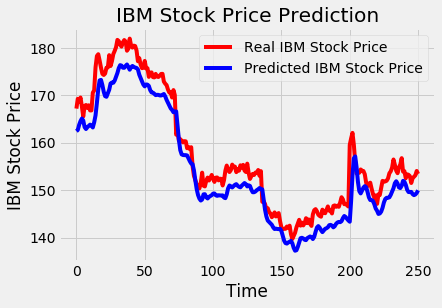

In [136]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [137]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.0844556458028185.


## Gated Recurrent Units RNN
Faster but poor results

In [106]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
2709/2709 [==============================] - 10s 4ms/step - loss: 0.1132
Epoch 2/50
2709/2709 [==============================] - 6s 2ms/step - loss: 0.0408
Epoch 3/50
2709/2709 [==============================] - 6s 2ms/step - loss: 0.0125
Epoch 4/50
2709/2709 [==============================] - 7s 3ms/step - loss: 0.0050
Epoch 5/50
2709/2709 [==============================] - 8s 3ms/step - loss: 0.0040
Epoch 6/50
2709/2709 [==============================] - 8s 3ms/step - loss: 0.0038
Epoch 7/50
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0038
Epoch 8/50
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0035
Epoch 9/50
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0035
Epoch 10/50
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0031
Epoch 11/50
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0031
Epoch 12/50
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0031


KeyboardInterrupt: 

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [32]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.2755427474511003.


## Bidirectional LSTM 
Using a Bidirectional LSTM for better results

In [50]:
# Biderctional Model
regressorBidirection = Sequential()
# First Bidirectional LSTM Layer
regressorBidirection.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1],1)))
regressorBidirection.add(Dropout(0.2))
# Second Bidirectional LSTM layer
regressorBidirection.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBidirection.add(Dropout(0.2))
# Third Bidirectional LSTM layer
regressorBidirection.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBidirection.add(Dropout(0.2))
# Fourth Bidirectional LSTM layer
regressorBidirection.add(Bidirectional(LSTM(units=50)))
regressorBidirection.add(Dropout(0.2))
# The output layer
regressorBidirection.add(Dense(units=1))

# Compiling the RNN
regressorBidirection.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressorBidirection.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
2709/2709 [==============================] - 112s 41ms/step - loss: 0.0211
Epoch 2/50
2709/2709 [==============================] - 103s 38ms/step - loss: 0.0091
Epoch 3/50
2709/2709 [==============================] - 105s 39ms/step - loss: 0.0077
Epoch 4/50
2709/2709 [==============================] - 104s 38ms/step - loss: 0.0056
Epoch 5/50
2709/2709 [==============================] - 115s 42ms/step - loss: 0.0053
Epoch 6/50
2709/2709 [==============================] - 106s 39ms/step - loss: 0.0043
Epoch 7/50
2709/2709 [==============================] - 107s 39ms/step - loss: 0.0039
Epoch 8/50
2709/2709 [==============================] - 109s 40ms/step - loss: 0.0037
Epoch 9/50
2709/2709 [==============================] - 113s 42ms/step - loss: 0.0035
Epoch 10/50
2709/2709 [==============================] - 112s 41ms/step - loss: 0.0032
Epoch 11/50
2709/2709 [==============================] - 106s 39ms/step - loss: 0.0030
Epoch 12/50
2709/2709 [=============================

In [51]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
bidirection_predicted_stock_price = regressorBidirection.predict(X_test)
bidirection_predicted_stock_price = sc.inverse_transform(bidirection_predicted_stock_price)

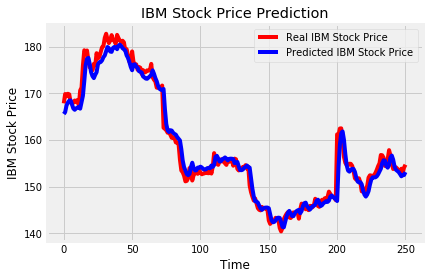

In [52]:
# Visualizing the results for GRU
plot_predictions(test_set,bidirection_predicted_stock_price)

In [81]:
# Evaluating GRU
return_rmse(test_set,bidirection_predicted_stock_price)

The root mean squared error is 1.9992020176634957.


## OHLC Chart
A plotly tool for plotting ohlc values

In [6]:
plotly_api_key = open('plotly_api.txt', 'r')

In [88]:
plotly.tools.set_credentials_file(username='magiciankartik', api_key='plotly_api_key')

In [92]:
trace = go.Ohlc(x=dataset.index,
                open=dataset.Open,
                high=dataset.High,
                low=dataset.Low,
                close=dataset.Close)
data = [trace]
py.iplot(data, filename='simple_ohlc')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~magiciankartik/0 or inside your plot.ly account where it is named 'simple_ohlc'
